In [9]:
# # #K562 G4 ChIP-seq bigwig
# # https://ftp.ncbi.nlm.nih.gov/geo/series/GSE107nnn/GSE107690/suppl/GSE107690_K562_High_confidence_peaks.bed.gz
# # # #to download for eg: wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1720nnn/GSM1720619/suppl/GSM1720619_K562_DRIP_peaks.bed.gz
# # !wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2876nnn/GSM2876090/suppl/GSM2876090_B_REP1.SLX-12319.K562_asynch_a_701_504.clean.bw
# !wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2876nnn/GSM2876091/suppl/GSM2876091_B_REP1.SLX-12319.K562_asynch_c_703_504.clean.bw
# !wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2876nnn/GSM2876093/suppl/GSM2876093_B_REP2.SLX-12320.K562_P9_Async_c_701_503.rmdup.clean.bw
# !wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2876nnn/GSM2876094/suppl/GSM2876094_B_REP2.SLX-12320.K562_P9_Async_b_701_502.rmdup.clean.bw
# !wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2876nnn/GSM2876095/suppl/GSM2876095_B_REP2.SLX-12320.K562_P9_Async_a_701_517.rmdup.clean.bw

In [10]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [11]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [12]:
%load_ext autoreload
%autoreload 2
import os
import cooler
import cooltools
import numpy as np
from cooltools import eigdecomp
import bioframe
from pathlib import Path
import multiprocess as mp

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


### some of the input cooler files that we used to combine/recombine/subset etc

In [13]:
# # #POLII degron (replicates merged)
# # !scp ghpcc:/nl/umw_job_dekker/users/av90w/distiller-run/20200417_remap_polIIdegron/results/coolers_library_group/PTB2539-NT.hg19.mapq_30.1000.mcool ./PolII-NT.hg19.mapq_30.1000.mcool
# # !scp ghpcc:/nl/umw_job_dekker/users/av90w/distiller-run/20200417_remap_polIIdegron/results/coolers_library_group/PTB2539-IAA.hg19.mapq_30.1000.mcool ./PolII-IAA.hg19.mapq_30.1000.mcool

# # #CTCF degron G1 sorted to redo the insulation at a finer scale with motif search (replicates merged)
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/distiller-run/20200805_G1sorted_442_replicate/results/coolers_library_group/G1-NT.hg19.mapq_30.1000.mcool ./G1-NT.hg19.1kb.mcool
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/distiller-run/20200805_G1sorted_442_replicate/results/coolers_library_group/G1-IAA.hg19.mapq_30.1000.mcool ./G1-IAA.hg19.1kb.mcool

In [14]:
# # cooler used for insulation calculations ...
# auxin: CkoC442-IAA48H-R1-T1__hg19.hg19.mapq_30.1000.mcool
# NT: CkoC442-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool

In [15]:
#DDX55 clones
# # DDX55sg2B NT - DDX55 clone that has lower than WT levels of DDX55 (not a complete knock out - impossible)
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/distiller-run/20200220_mapping_for_dot_calling/results/coolers_library/CkoCT442-DDX55sg2-B-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool ./
# # AAVS1 clone - kind of like WT, ... hopefully looks like NT-CTCF control.... - no crazy insulation shifts...
# # NT
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/distiller-run/20200220_mapping_for_dot_calling/results/coolers_library/CkoCT442-AAVS1sg2-4-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool ./
    
###################################################### not yet downloaded below ...
# DDX55sg2B IAA
# /nl/umw_job_dekker/users/av90w/distiller-run/20200220_mapping_for_dot_calling/results/coolers_library/CkoCT442-DDX55sg2-B-IAA-R1-T1__hg19.hg19.mapq_30.1000.mcool
# DDX55sg27 NT
# /nl/umw_job_dekker/users/av90w/distiller-run/20200220_mapping_for_dot_calling/results/coolers_library/CkoCT442-DDX55sg2-7-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool
# DDX55sg27 IAA
# /nl/umw_job_dekker/users/av90w/distiller-run/20200220_mapping_for_dot_calling/results/coolers_library/CkoCT442-DDX55sg2-7-IAA-R1-T1__hg19.hg19.mapq_30.1000.mcool
# #AAVS1 clone
# NT
# !scp ghpcc:/nl/umw_job_dekker/users/av90w/distiller-run/20200220_mapping_for_dot_calling/results/coolers_library/CkoCT442-AAVS1sg2-4-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool ./
# IAA
# /nl/umw_job_dekker/users/av90w/distiller-run/20200220_mapping_for_dot_calling/results/coolers_library/CkoCT442-AAVS1sg2-4-IAA-R1-T1__hg19.hg19.mapq_30.1000.mcool


In [16]:
ins_samples = {
    "Hap1-WT-combined.hg19" : "Hap1-WT-combined.mcool",
    "PolII-IAA.hg19" : "PolII-IAA.hg19.mapq_30.1000.mcool",
    "PolII-NT.hg19" : "PolII-NT.hg19.mapq_30.1000.mcool",
    "all_CTCF_combined.hg19" : "all_combined.mcool",
    "noCTCF_IAA_combined.hg19" : "noCTCF_IAA_combined.mcool",
    
    "all_CTCF_combined.hg19" : "all_combined.mcool",
    "noCTCF_IAA_combined.hg19" : "noCTCF_IAA_combined.mcool",
    
    "CkoCT442_NT_pool.hg19" : "CkoCT442-NT-pool.mcool",
    "CkoCT442_IAA_pool.hg19" : "CkoCT442-IAA-pool.mcool",

    "CkoC442-IAA48H-R1-T1.hg19" : "CkoC442-IAA48H-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoC442-NT-R1-T1.hg19" : "./wt_like_coolers_to_combine/CkoC442-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoCT442-AAVS1sg2-4-NT-R1-T1.hg19" : "CkoCT442-AAVS1sg2-4-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoCT442-DDX55sg2-B-NT-R1-T1.hg19" : "CkoCT442-DDX55sg2-B-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "G1-NT.hg19" : "G1-NT.hg19.1kb.mcool",
    "G1-IAA.hg19" : "G1-IAA.hg19.1kb.mcool",
}


In [18]:
%%bash
cname="./CkoCT442-NT-pool.mcool"
for uri in $(cooler ls $cname);
do
    echo $uri
    cooler balance --check $uri
done

./CkoCT442-NT-pool.mcool::/resolutions/1000
./CkoCT442-NT-pool.mcool::/resolutions/1000 is balanced.
./CkoCT442-NT-pool.mcool::/resolutions/2000
./CkoCT442-NT-pool.mcool::/resolutions/2000 is balanced.
./CkoCT442-NT-pool.mcool::/resolutions/5000
./CkoCT442-NT-pool.mcool::/resolutions/5000 is balanced.
./CkoCT442-NT-pool.mcool::/resolutions/10000
./CkoCT442-NT-pool.mcool::/resolutions/10000 is balanced.
./CkoCT442-NT-pool.mcool::/resolutions/25000
./CkoCT442-NT-pool.mcool::/resolutions/25000 is balanced.
./CkoCT442-NT-pool.mcool::/resolutions/50000
./CkoCT442-NT-pool.mcool::/resolutions/50000 is balanced.
./CkoCT442-NT-pool.mcool::/resolutions/100000
./CkoCT442-NT-pool.mcool::/resolutions/100000 is balanced.
./CkoCT442-NT-pool.mcool::/resolutions/250000
./CkoCT442-NT-pool.mcool::/resolutions/250000 is balanced.
./CkoCT442-NT-pool.mcool::/resolutions/500000
./CkoCT442-NT-pool.mcool::/resolutions/500000 is balanced.
./CkoCT442-NT-pool.mcool::/resolutions/1000000
./CkoCT442-NT-pool.mcool::

In [19]:
binsize = 2_000
binsize_human = f"{int(binsize/1_000)}kb"
diamond = 20_000
diamond_human = f"{int(diamond/1_000)}kb"

hg19_chromsizes = bioframe.fetch_chromsizes("hg19")

# iterate over samples to calculate insulation on:
for k,cname in ins_samples.items():
    target_bw_file = Path(f"{k}.{binsize_human}.{diamond_human}.bw")
    if target_bw_file.is_file():
        print("already exist !")
        print(target_bw_file)
        continue
    else:
        print("working on ...")
        print(k,cname)
        ######################################
        ! cooltools diamond-insulation \
            -o {k}.{binsize_human}.{diamond_human}.tsv \
            {cname}::/resolutions/{binsize} \
            {diamond}
        ###################################### 
        df = bioframe.read_table(
                f"{k}.{binsize_human}.{diamond_human}.tsv",
                header=0
        )
        ######################################
        bioframe.to_bigwig(
            df,
            hg19_chromsizes,
            f"{k}.{binsize_human}.{diamond_human}.bw",
            value_field = f"log2_insulation_score_{diamond}"
        )


already exist !
Hap1-WT-combined.hg19.2kb.20kb.bw
already exist !
PolII-IAA.hg19.2kb.20kb.bw
already exist !
PolII-NT.hg19.2kb.20kb.bw
already exist !
all_CTCF_combined.hg19.2kb.20kb.bw
already exist !
noCTCF_IAA_combined.hg19.2kb.20kb.bw
working on ...
CkoCT442_NT_pool.hg19 CkoCT442-NT-pool.mcool
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
bedGraphToBigWig /tmp/tmps3nzfx_1.bg /tmp/tmpu3cy3cgc.chrom.sizes CkoCT442_NT_pool.hg19.2kb.20kb.bw
working on ...
CkoCT442_IAA_pool.hg19 CkoCT442-IAA-pool.mcool
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
bedGraphToBigWig /tmp/tmphbmuznw4.bg /tmp/tmpdd5t_2u9.chrom.sizes CkoCT442_IAA_pool.hg19.2kb.20kb.bw
already exist !
CkoC442-IAA48H-R1-T1.hg19.2kb.20kb.bw
already exist !
CkoC442-NT-R1-T1.hg19.2kb.20kb.bw
already exist !
CkoCT442-AAVS1sg2-4-NT-R1-T1.hg19.2kb.20kb.bw
already exist !
CkoCT442-DDX55sg2-B-NT-R1-T1.hg19.2kb.20kb.bw
already exist !
G1-NT.hg19.2kb.20kb.bw
already exist !
G1-IAA.hg19.2kb.20kb.bw


In [39]:
!cooler info all_combined.mcool::/resolutions/25000 | grep sum
!cooler info all_combined.mcool::/resolutions/25000 | grep nnz
!cooler info noCTCF_IAA_combined.mcool::/resolutions/25000 | grep sum
!cooler info noCTCF_IAA_combined.mcool::/resolutions/25000 | grep nnz

    "sum": 1003109304
    "nnz": 435281435,
    "sum": 574751797
    "nnz": 226147479,


In [25]:
def rename_arms(name):
    """
    turn UCSC genomic region name
    into a human readable name of chrom arm
    """
    chrom,coords = name.split(":")
    start,end = coords.split("-")
    if start == "0":
        return chrom+"p"
    else:
        return chrom+"q"

hg19_chromsizes = bioframe.fetch_chromsizes('hg19', as_bed=True)
hg19_cens = bioframe.fetch_centromeres('hg19')
hg19_arms = bioframe.split(hg19_chromsizes, hg19_cens, cols_points=['chrom', 'mid'])
# # Select only chromosomes that are present in the cooler. 
# # This step is typically not required! we call it only because the test data are reduced. 
# hg19_chromsizes = hg19_chromsizes.set_index("chrom").loc[hg19_chromsizes.chrom].reset_index() 
hg19_arms = hg19_arms.set_index("chrom").loc[hg19_chromsizes.chrom.values[:-1]].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg19_arms = bioframe.parse_regions(hg19_arms)
hg19_arms["name"] = hg19_arms["name"].apply(rename_arms)
hg19_arms.head()

,chrom,start,end,name
0,chr1,0,125200000,chr1p
1,chr1,125200000,249250621,chr1q
2,chr2,0,93650000,chr2p
3,chr2,93650000,243199373,chr2q
4,chr3,0,90900000,chr3p


In [26]:
# CkoC44-IAA48H-R1-T1__hg19.hg19.mapq_30.1000.mcool
# clr = cooler.Cooler("./wt_like_coolers_to_combine/CkoC442-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool::/resolutions/250000")
# clr = cooler.Cooler("NT_combined.100kb.cool")
clr = cooler.Cooler("noCTCF_IAA_combined.mcool::/resolutions/25000")

In [27]:
# let's calculate gene coverage by pulling mRNA data from USCS
# for our hg19 genome ...
# this would need to be repeated for every genome, every binsize, etc
# probably better to download mRNA data locally to avoid redownloading ...
gene_cov_df = bioframe.frac_gene_coverage(
                clr.bins()[:],
                "hg19"
                )

In [28]:
nproc = 4
if nproc > 1:
    pool = mp.Pool(nproc)
    map_ = pool.map
else:
    map_ = map

res = eigdecomp.cooler_cis_eig(
    clr=clr,
    bins=gene_cov_df,
    regions=hg19_arms,
    n_eigs=3,
    phasing_track_col='coverage',
    balance='weight',
    ignore_diags=2,
    clip_percentile=99.9,
    sort_metric=None,
    map = map_
)

In [29]:
eigvals, eigvecs = res
chr1q_region = tuple(hg19_arms.iloc[1])[:-1]
ev1 = bioframe.select(eigvecs, chr1q_region)["E1"].values
# bioframe.select(a,'chr21:0-12600000')

In [30]:
# save compartment calls as bigwig
bioframe.to_bigwig(
    eigvecs,
    bioframe.fetch_chromsizes("hg19"),
    "noCTCF_IAA_combined.EV1.25kb.bw",
    value_field="E1"
)

bedGraphToBigWig /tmp/tmp4k9t3sao.bg /tmp/tmpcejqfh2w.chrom.sizes noCTCF_IAA_combined.EV1.25kb.bw


In [31]:
a,b = res
chr1q_region = tuple(hg19_arms.iloc[1])[:-1]
ev1 = bioframe.select(b, chr1q_region)["E1"].values

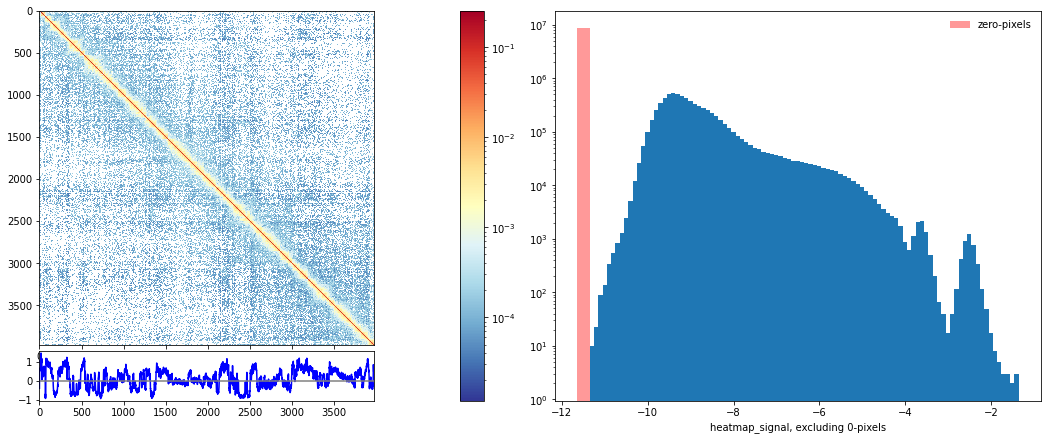

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(15,6),constrained_layout=True)
gs = fig.add_gridspec(1,3,width_ratios=[1,0.05,1])
axl = fig.add_subplot(gs[0,0])
cax = fig.add_subplot(gs[0,1])
axr = fig.add_subplot(gs[0,2])

hm = clr.matrix(balance=True).fetch(tuple(hg19_arms.iloc[1])[:-1])
valid_mask = np.nan_to_num(hm).sum(axis=0) == 0.
hm = hm[~valid_mask][:,~valid_mask]

ccc = axl.imshow(hm,cmap="RdYlBu_r",interpolation="nearest",norm=LogNorm())
plt.colorbar(ccc,cax=cax)

divider = make_axes_locatable(axl)
axev = divider.append_axes("bottom", size="15%", pad=0.08)

axev.plot(ev1[~valid_mask],'b-')
axev.axhline(0,color="grey")
axev.set_xlim(0,np.sum(~valid_mask))

# color histogram
_1, bin_edges, _2 = axr.hist(np.nan_to_num(np.log(hm[hm>0])).flatten(),bins=100,log=True)
axr.bar(bin_edges[0],np.sum(hm==0),width=-.3,align="edge",color="red",alpha=0.4,label="zero-pixels")
axr.set_xlabel("heatmap_signal, excluding 0-pixels")
axr.legend(frameon=False)